In [1]:
%matplotlib inline
import gzip
import pickle
import os
import struct
import sys

from math import floor, sqrt, ceil

import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from scipy import optimize as opt
from scipy.io import loadmat


def read_data():  
    training_set_file = ['data/data_batch_{}.bin'.format(i) for i in range(1, 6)]
    test_set_file = 'data/test_batch.bin'
    label_file = 'data/batches.meta.txt'
    
    X = np.array([])
    
    for tfile in training_set_file:
        with open(tfile, 'rb') as f:
            X = np.append(X, np.fromfile(f, dtype=np.uint8))
    X = X.reshape(-1, 3073)
    y = X[:, 0].reshape(-1, 1)
    X = X[:, 1:]

    with open(test_set_file, 'rb') as f:
        X_test = np.fromfile(f, dtype=np.uint8)
    X_test = X_test.reshape(-1, 3073)
    y_test = X_test[:, 0].reshape(-1, 1)
    X_test = X_test[:, 1:]
    
    labels = []
    with open(label_file, 'r') as f:
        for line in f:
            labels.append(line.strip('\n'))
    labels = np.array(labels)
    return X, y, X_test, y_test, labels


def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def sigmoid_gradient(z):
    return sigmoid(z) * (1-sigmoid(z))


def feedforward(X, theta1, theta2):
    # Feedforward
    m, n = X.shape  # m = 5000, n = 400
    a1 = np.append(np.ones((m, 1)), X, axis=1)  # a1: 5000 x 401
    z2 = a1.dot(theta1.T)  # z2: 5000 x 25
    a2 = np.append(np.ones((m, 1)), sigmoid(z2), axis=1)  # a2: 5000 x 26
    z3 = a2.dot(theta2.T)  # z3: 5000 x 10
    a3 = sigmoid(z3)  # a3: 5000 x 10
    h = a3
    return h, a1, z2, a2, z3


def cost_func(nn_params, input_layer_size, hidden_layer_size, cate_labels,
              X, y, lamb):
    m, n = X.shape  # m = 5000, n = 400
    theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].copy()
    theta1 = theta1.reshape((hidden_layer_size, input_layer_size + 1))

    theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].copy()
    theta2 = theta2.reshape((cate_labels, hidden_layer_size + 1))

    encoder = OneHotEncoder(sparse=False)
    y_mat = encoder.fit_transform(y)

    h, a1, z2, a2, z3 = feedforward(X, theta1, theta2)

    J = -1/m*(np.sum(y_mat * np.log(h))+np.sum((1-y_mat) * np.log(1-h)))

    # Regularize
    regular_term = np.sum(theta1[:, 1:]**2) + np.sum(theta2[:, 1:]**2)
    regular_term = lamb / (2 * m) * regular_term
    J += regular_term

    return J


def back_propagation(nn_params, input_layer_size, hidden_layer_size,
                     cate_labels, X, y, lamb):
    # Backpropagation
    m, n = X.shape  # m = 5000, n = 400
    theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].copy()
    theta1 = theta1.reshape((hidden_layer_size, input_layer_size + 1))

    theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].copy()
    theta2 = theta2.reshape((cate_labels, hidden_layer_size + 1))

    encoder = OneHotEncoder(sparse=False)
    y_mat = encoder.fit_transform(y)

    h, a1, z2, a2, z3 = feedforward(X, theta1, theta2)

    d3 = h - y_mat
    d2 = d3.dot(theta2[:, 1:]) * sigmoid_gradient(z2)
    delta1 = d2.T.dot(a1)
    delta2 = d3.T.dot(a2)
    theta1_grad = delta1 / m
    theta2_grad = delta2 / m

    theta1[:, 0] = 0
    theta2[:, 0] = 0
    theta1_grad += theta1 * lamb / m
    theta2_grad += theta2 * lamb / m

    grad = np.append(theta1_grad.flatten(), theta2_grad.flatten())
    return grad


def rand_init_weights(lin, lout):
    init_e = 0.12
    w = np.random.random_sample((lout, lin + 1)) * 2 * init_e - init_e
    return w


def predict(theta1, theta2, X):
    m, n = X.shape

    h1 = sigmoid(np.append(np.ones((m, 1)), X, axis=1).dot(theta1.T))
    h2 = sigmoid(np.append(np.ones((m, 1)), h1, axis=1).dot(theta2.T))

    hypothesis = np.argmax(h2, axis=1)

    return hypothesis


def callback(nn_params):
    global iter_times
    global costs
    iter_times += 1
    J_train = cost_func(nn_params, input_layer_size, hidden_layer_size,
                        cate_labels, X, y, lamb)
    J_test = cost_func(nn_params, input_layer_size, hidden_layer_size,
                       cate_labels, X_test, y_test, lamb)
    costs.append((iter_times, J_train, J_test))
    sys.stdout.flush()
    sys.stdout.write('Iteration {:>4d}| Cost: {:.6f}\r'.format(iter_times, J_train))

In [2]:
X, y, X_test, y_test, labels = read_data()
X = X / 255.
X_test = X_test / 255.

KeyboardInterrupt: 

In [29]:
input_layer_size = X.shape[1]
hidden_layer_size = 100
cate_labels = 10

m, n = X.shape
print('Training set size: {} x {}'.format(m, n))
print('Test set size: {} x {}'.format(*X_test.shape))

Training set size: 50000 x 3072
Test set size: 10000 x 3072


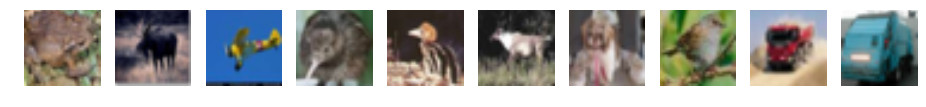

Labels:  ['frog' 'deer' 'airplane' 'bird' 'bird' 'deer' 'dog' 'bird' 'truck' 'truck']


In [30]:
plt.figure(figsize=(16, 16))
sel = np.random.choice(m, 10, replace=False)
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow((X[sel[i]]).reshape((32, 32, 3), order='F').transpose(1, 0, 2))
    plt.axis('off')
plt.show()
print('Labels: ', labels[y[sel].ravel().astype(int)])

In [41]:
lamb = 1
iter_times = 0
initial_theta1 = rand_init_weights(input_layer_size, hidden_layer_size)
initial_theta2 = rand_init_weights(hidden_layer_size, cate_labels)
initial_nn_params = np.append(initial_theta1, initial_theta2)

print('Traing Neural Network...')
options = {'full_output': True, 'maxiter': 50, 'callback': callback}

costs = []
nn_params, cost, *rest = opt.fmin_cg(
    cost_func, x0=initial_nn_params, fprime=back_propagation,
    args=(input_layer_size, hidden_layer_size,
          cate_labels, X, y, lamb), **options)

theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].copy()
theta1 = theta1.reshape((hidden_layer_size, input_layer_size + 1))

theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].copy()
theta2 = theta2.reshape((cate_labels, hidden_layer_size + 1))

Traing Neural Network...
         Current function value: 2.915982
         Iterations: 50
         Function evaluations: 76
         Gradient evaluations: 76


Visualizing Learning Curves...


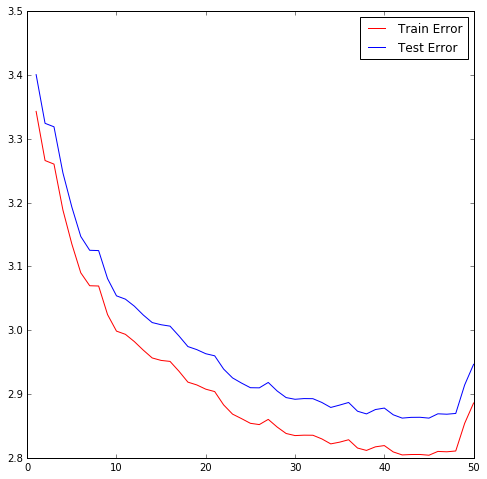

Start Predicting on Training set...


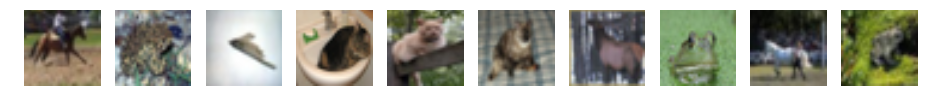

Labels:  ['horse' 'frog' 'airplane' 'cat' 'cat' 'cat' 'deer' 'frog' 'horse' 'frog']
Predict:  ['deer' 'airplane' 'airplane' 'bird' 'bird' 'airplane' 'automobile' 'bird'
 'dog' 'deer']
Training Set Accurary: 31.00%

Start Predicting on Test set...


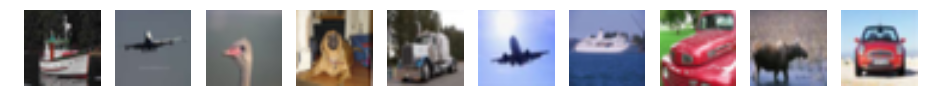

Labels:  ['ship' 'airplane' 'bird' 'dog' 'truck' 'airplane' 'ship' 'automobile'
 'deer' 'automobile']
Predict:  ['airplane' 'deer' 'bird' 'truck' 'ship' 'horse' 'airplane' 'airplane'
 'ship' 'automobile']
Test Set Accurary: 30.28%


In [42]:
print('Visualizing Learning Curves...')
plt.figure(figsize=(8, 8))
costs = np.array(costs)
plt.plot(costs[:, 0], costs[:, 1], color='r', label='Train Error')
plt.plot(costs[:, 0], costs[:, 2], color='b', label='Test Error')
plt.legend()
plt.show()

print('Start Predicting on Training set...')
h = predict(theta1, theta2, X).reshape((-1, 1))
m, n = X.shape
plt.figure(figsize=(16, 16))
sel = np.random.choice(m, 10, replace=False)
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow((X[sel[i]]).reshape((32, 32, 3), order='F').transpose(1, 0, 2))
    plt.axis('off')
plt.show()
print('Labels: ', labels[y[sel].ravel().astype(int)])
print('Predict: ', labels[h[sel].ravel().astype(int)])
print('Training Set Accurary: {:.2%}'.format(np.sum(h == y) / m))

print()

print('Start Predicting on Test set...')
h = predict(theta1, theta2, X_test).reshape((-1, 1))
plt.figure(figsize=(16, 16))
m, n = X_test.shape
sel = np.random.choice(m, 10, replace=False)
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow((X[sel[i]]).reshape((32, 32, 3), order='F').transpose(1, 0, 2))
    plt.axis('off')
plt.show()
print('Labels: ', labels[y[sel].ravel().astype(int)])
print('Predict: ', labels[h[sel].ravel().astype(int)])
print('Test Set Accurary: {:.2%}'.format(np.sum(h == y_test) / m))